<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 1. IMPORT LIBRARY 🍎
</b></font>
</div>

In [3]:
import os
import numpy as np
from glob import glob
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

np.random.seed(2025)

2025-06-16 02:56:45.904621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750042606.142277      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750042606.208773      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 2. DATA LOADER 🍎</b></font>
</div>

In [4]:
class CustomDataset:
    def __init__(self, root, data_type, transformations=None, im_files=[".png", ".jpg", ".jpeg"]):
        self.transformations, self.data_type = transformations, data_type
        self.im_paths = []
        for im_file in im_files:
            self.im_paths.extend(glob(f"{root}/{data_type}/*/*{im_file}"))

        self.cls_names, self.cls_counts = {}, {}
        count = 0
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1        

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        if self.transformations:
            im = self.transformations(im)
        gt = self.cls_names[self.get_class(im_path)]
        return im, gt

    def get_data(self):
        images, labels = [], []
        for idx in range(len(self.im_paths)):
            im, label = self[idx]
            images.append(im)
            labels.append(label)
        return np.array(images), np.array(labels)

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 3. PREPROCESSING & LOAD DATASET 🍎</b></font>
</div>

In [5]:
def preprocess(image, im_size=64):
    image = image.resize((im_size, im_size))
    image = np.array(image).astype(np.float32) / 255.0
    return image

root = "/kaggle/input/fruit-ripeness-unripe-ripe-and-rotten/archive (1)/dataset/dataset"
im_size = 64

tfs = lambda im: preprocess(im, im_size=im_size)

train_dataset = CustomDataset(root=root, data_type="train", transformations=tfs)
test_dataset = CustomDataset(root=root, data_type="test", transformations=tfs)

X_train_full, y_train_full = train_dataset.get_data()
X_test, y_test = test_dataset.get_data()

# Split Train-Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=2025, stratify=y_train_full)

print(f"Train Shape: {X_train.shape}, Validation Shape: {X_val.shape}, Test Shape: {X_test.shape}")
print(f"Jumlah Data:")
print(f"- Train      : {len(X_train)} samples")
print(f"- Validation : {len(X_val)} samples")
print(f"- Test       : {len(X_test)} samples")

Train Shape: (12809, 64, 64, 3), Validation Shape: (4270, 64, 64, 3), Test Shape: (3889, 64, 64, 3)
Jumlah Data:
- Train      : 12809 samples
- Validation : 4270 samples
- Test       : 3889 samples


<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 4. VISUALISASI DATASET🍎</b></font>
</div>

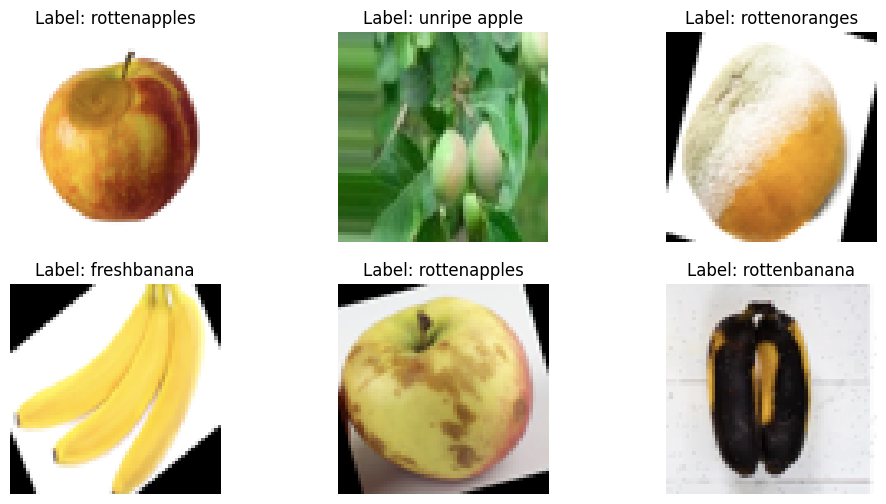

In [6]:
class_names = list(train_dataset.cls_names.keys())

plt.figure(figsize=(12, 6))
for i in range(6):
    idx = random.randint(0, len(X_train) - 1)
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Label: {class_names[y_train[idx]]}")
    plt.axis('off')
plt.show()

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 5. MODEL CNN🍎</b></font>
</div>

In [18]:
num_classes = len(train_dataset.cls_names)

cnn = models.Sequential([
    layers.Input(shape=(im_size, im_size, 3)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3), 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax')
])


cnn.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

cnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,361 (2.61 MB)

 Trainable params: 684,361 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 6. CALLBACK 🍎</b></font>
</div>

In [19]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 7. TRAINING CNN 🍎</b></font>
</div>

In [20]:
history = cnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
400/401 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3896 - loss: 1.5545
Epoch 1: val_accuracy improved from -inf to 0.71686, saving model to best_model.keras
401/401 ━━━━━━━━━━━━━━━━━━━━ 54s 125ms/step - accuracy: 0.3902 - loss: 1.5528 - val_accuracy: 0.7169 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 2/50
400/401 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6626 - loss: 0.8188
Epoch 2: val_accuracy improved from 0.71686 to 0.73208, saving model to best_model.keras
401/401 ━━━━━━━━━━━━━━━━━━━━ 49s 121ms/step - accuracy: 0.6627 - loss: 0.8186 - val_accuracy: 0.7321 - val_loss: 0.6069 - learning_rate: 0.0010
Epoch 3/50
400/401 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7043 - loss: 0.7081
Epoch 3: val_accuracy improved from 0.73208 to 0.75199, saving model to best_model.keras
401/401 ━━━━━━━━━━━━━━━━━━━━ 49s 123ms/step - accuracy: 0.7043 - loss: 0.7081 - val_accuracy: 0.7520 - val_loss: 0.5590 - learning_rate: 0.0010
Epoch 4/50
400/401 ━━━━━━━━━━━━━━━━━━━━ 

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 8. VISUALISASI TRAINING 🍎</b></font>
</div>

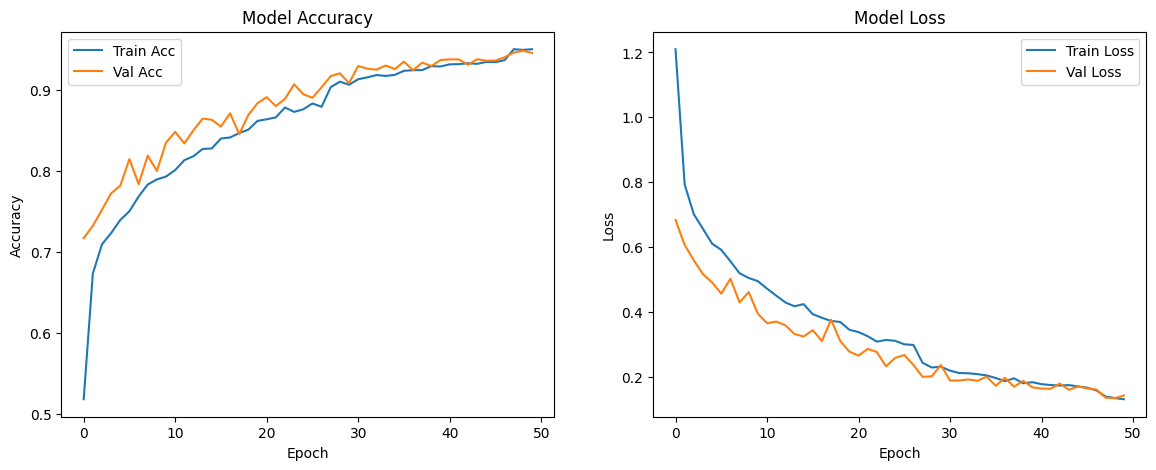

In [21]:
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 9. EVALUASI MODEL 🍎</b></font>
</div>

In [24]:
best_model = tf.keras.models.load_model('best_model.keras')
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9926 - loss: 0.0241

Test Accuracy: 0.9735


<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 10. METRIK & CONFUSION MATRIX 🍎</b></font>
</div>

122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
               precision    recall  f1-score   support

 rottenbanana     0.9981    1.0000    0.9991       530
 freshoranges     0.9872    0.9948    0.9910       388
rottenoranges     0.9950    0.9901    0.9925       403
  freshbanana     0.9974    1.0000    0.9987       381
 rottenapples     0.9917    0.9967    0.9942       601
  freshapples     0.9874    0.9924    0.9899       395
 unripe apple     0.9171    0.9054    0.9112       391
unripe banana     0.9525    0.9525    0.9525       400
unripe orange     0.9169    0.9100    0.9134       400

     accuracy                         0.9735      3889
    macro avg     0.9715    0.9713    0.9714      3889
 weighted avg     0.9734    0.9735    0.9734      3889



<Figure size 800x600 with 0 Axes>

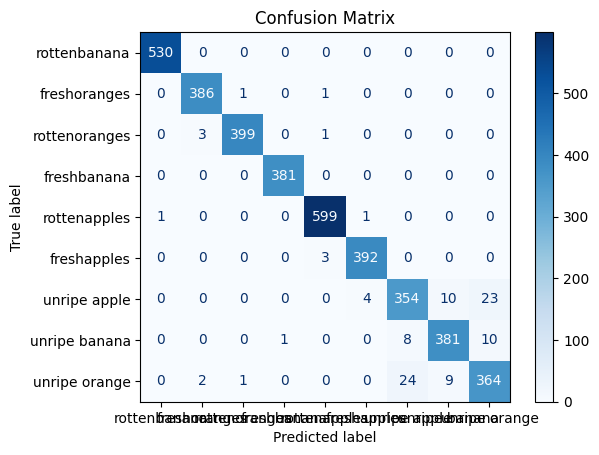

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prediksi pada data test
y_pred = np.argmax(best_model.predict(X_test), axis=1)

# Classification Report
report = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 11. VISUALISASI PREDIKSI 🍎</b></font>
</div>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


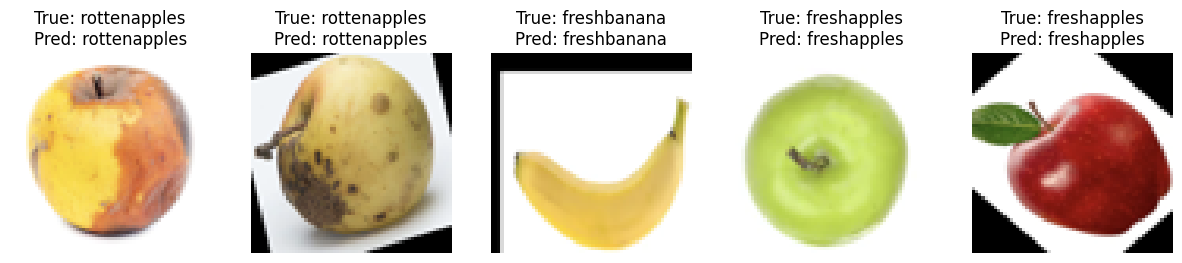

In [26]:
plt.figure(figsize=(15, 5))
indices = random.sample(range(len(X_test)), 5)

for i, idx in enumerate(indices):
    img = X_test[idx]
    label = y_test[idx]
    prediction = np.argmax(best_model.predict(np.expand_dims(img, axis=0)))
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[label]}\nPred: {class_names[prediction]}")
    plt.axis('off')

plt.show()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 12. CONFIDENCE 🍎</b></font>
</div>

122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


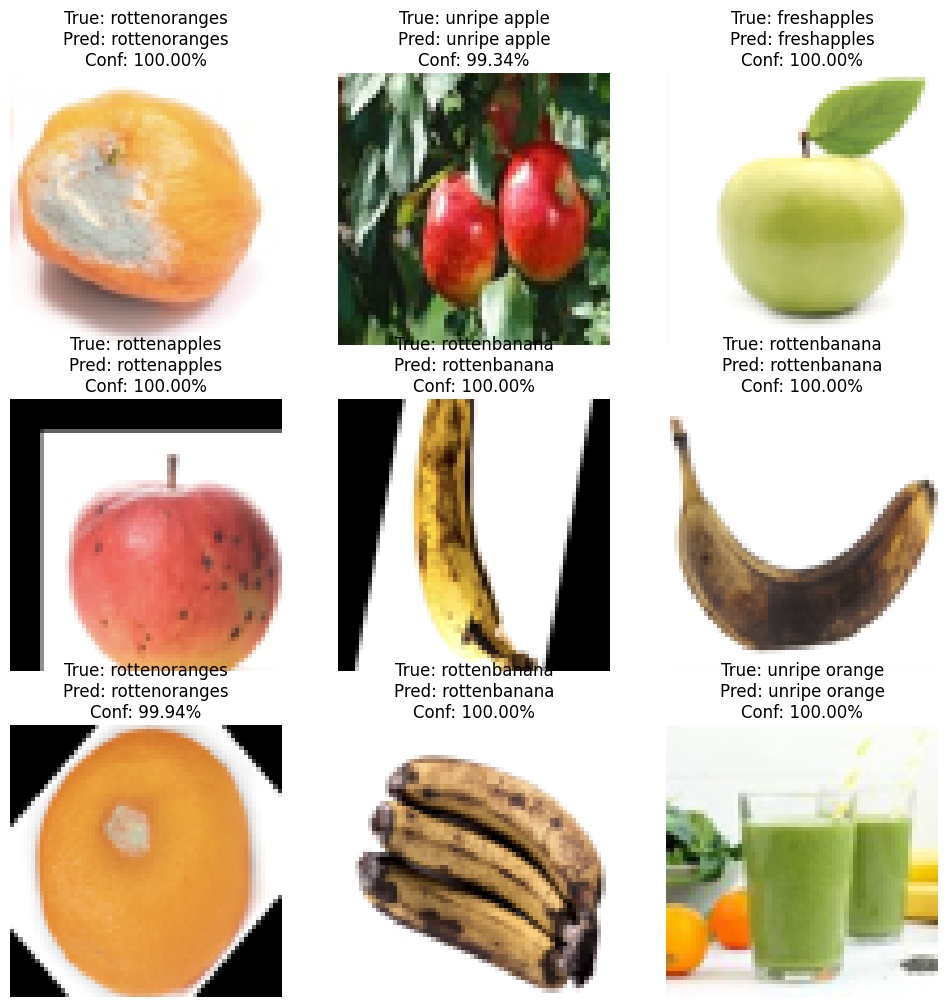

In [28]:
idx = np.random.choice(len(X_test), 9, replace=False)
y_pred = cnn.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
plt.figure(figsize=(12, 12))
for i, index in enumerate(idx):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[index])
    true_label = list(train_dataset.cls_names.keys())[list(train_dataset.cls_names.values()).index(y_test[index])]
    pred_label = list(train_dataset.cls_names.keys())[y_pred_labels[index]]
    confidence = np.max(y_pred[index]) * 100  # Confidence score dalam persen
    plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%')
    plt.axis('off')
plt.show()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 13. KONVERSI KE TFLITE 🍎</b></font>
</div>

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Simpan TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil disimpan sebagai model.tflite")

Saved artifact at '/tmp/tmpwq65ckwr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  139909481266448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139909481266064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139909481263760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139909481265488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139909481264528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139909481263952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139909481262608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139909481264144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139909481266256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139909481267024: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil di

W0000 00:00:1750050486.758735      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750050486.758788      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
